In [21]:
%load_ext autoreload
%autoreload 2

import logging
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader
from pyro.nn import DenseNN
from pyro.distributions.transforms import AffineCoupling

from vaemcmc.models.encoders import EncoderMLP
from vaemcmc.models.decoders import DecoderMLP
from vaemcmc.vae import VAE, VAETarget
from vaemcmc.mcmc import ISIRKernel
from vaemcmc.dataset import SyntheticDataset
from vaemcmc.trainer import Trainer
from vaemcmc.distributions.likelihood import NormalLikelihood
from vaemcmc.viz.synthetic import plot_kde, plot_chain, scatter
from vaemcmc.models.rnvp import RNVP, FlowML

from vaemcmc.distributions.synthetic import Funnel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
AMB_DIM = 100
LAT_DIM = 32
HIDDEN_DIM = 32
NUM_BLOCKS = 2

xlim = (-6, 6)
ylim = (-3, 3)
PROJ = (AMB_DIM - 2, AMB_DIM - 1)

target = Funnel(dim=AMB_DIM, a=1)

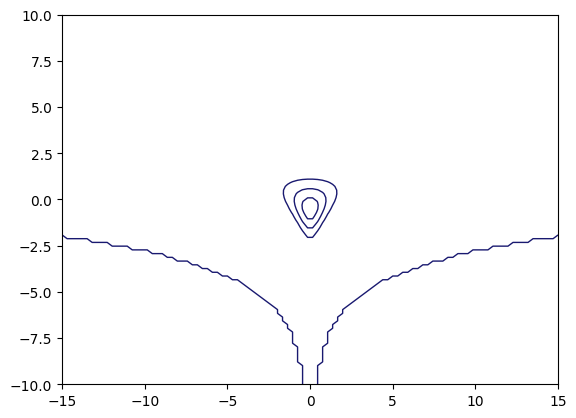

In [23]:
ax = plt.subplot()
target.plot_2d_contour(ax)
# ax.axis('square')

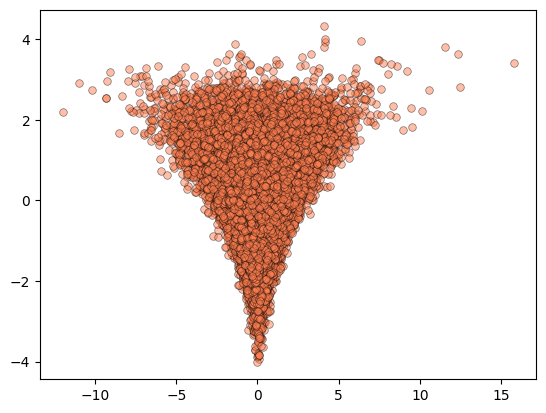

In [24]:
true_sample = target.sample((500 * 100,))
scatter(true_sample[:, PROJ]);
# plt.axis('auto')
# plt.show()

In [25]:

# train_dataset = TensorDataset(target.sample(1000))
train_dataset = SyntheticDataset(target.sample((10000,)))
train_dataloader = DataLoader(train_dataset, batch_size=16)

val_dataset = SyntheticDataset(target.sample((10000,)))
val_dataloader = DataLoader(val_dataset, batch_size=16)

encoder = EncoderMLP(AMB_DIM, 2 * LAT_DIM, HIDDEN_DIM, n_layers=NUM_BLOCKS)
decoder = DecoderMLP(LAT_DIM, AMB_DIM, HIDDEN_DIM, n_layers=NUM_BLOCKS)

sigma = 1.
likelihood = NormalLikelihood(sigma)
vae = VAE(encoder, decoder, likelihood)
optimizer = torch.optim.Adam(vae.parameters(), lr=3e-4)

logging.basicConfig(format='%(asctime)s [%(levelname)-8s] %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.INFO)
    
trainer = Trainer(vae, optimizer, train_dataloader, val_dataloader=val_dataloader, logger=logger)


In [26]:
trainer.train(25)

2023-05-30 11:10:32,037 [INFO    ] 4%|4         | 1/25 [00:01<00:25,  1.07s/it]
2023-05-30 11:10:32,783 [INFO    ] Loss: 180.25083923339844
2023-05-30 11:10:34,276 [INFO    ] 12%|#2        | 3/25 [00:03<00:24,  1.10s/it]
2023-05-30 11:10:34,478 [INFO    ] Loss: 179.8880615234375
2023-05-30 11:10:35,524 [INFO    ] 16%|#6        | 4/25 [00:04<00:24,  1.16s/it]
2023-05-30 11:10:36,647 [INFO    ] Loss: 162.23291015625
2023-05-30 11:10:38,526 [INFO    ] 24%|##4       | 6/25 [00:07<00:26,  1.37s/it]
2023-05-30 11:10:39,011 [INFO    ] Loss: 215.4647674560547
2023-05-30 11:10:39,905 [INFO    ] 28%|##8       | 7/25 [00:08<00:24,  1.38s/it]
2023-05-30 11:10:41,669 [INFO    ] Loss: 183.75753784179688
2023-05-30 11:10:42,948 [INFO    ] 36%|###6      | 9/25 [00:11<00:22,  1.43s/it]
2023-05-30 11:10:43,789 [INFO    ] Loss: 179.93902587890625
2023-05-30 11:10:45,590 [INFO    ] 44%|####4     | 11/25 [00:14<00:19,  1.37s/it]
2023-05-30 11:10:45,841 [INFO    ] Loss: 179.03167724609375
2023-05-30 11:10:4

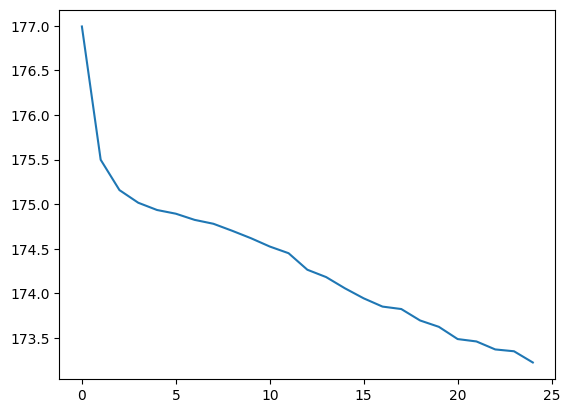

In [27]:
plt.plot(trainer.training_stats['epoch_loss'])

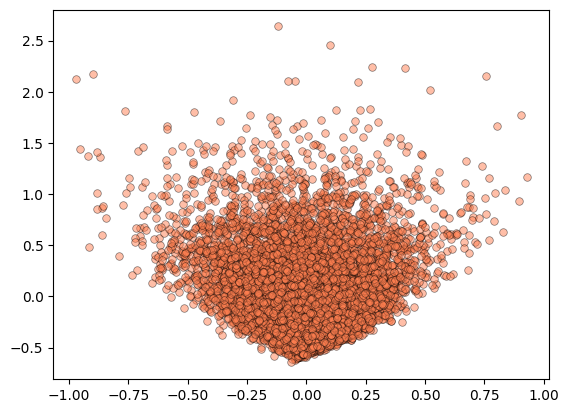

In [28]:
sample = vae.sample((10000,)).detach().cpu()
scatter(sample[:, PROJ]);

(-3.0, 3.0)

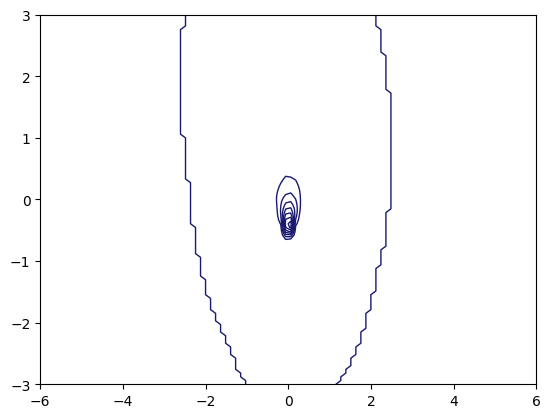

In [29]:
sample = vae.sample((20000,)).detach().cpu()
fig = plot_kde(sample[..., PROJ], xlim, ylim)
ax = fig.get_axes()[0]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_aspect('equal')

In [30]:
z_start = vae.prior.sample((100,))

target_vae = VAETarget(vae, target)
proposal = vae.prior
isir_kernel = ISIRKernel(target_vae, proposal=proposal, n_particles=25)

In [31]:
chain = isir_kernel.run(z_start, 500, 500)

In [32]:
x_start = vae.decode(z_start).detach().cpu()
vae_x_chain = vae.decode(chain).detach().cpu()

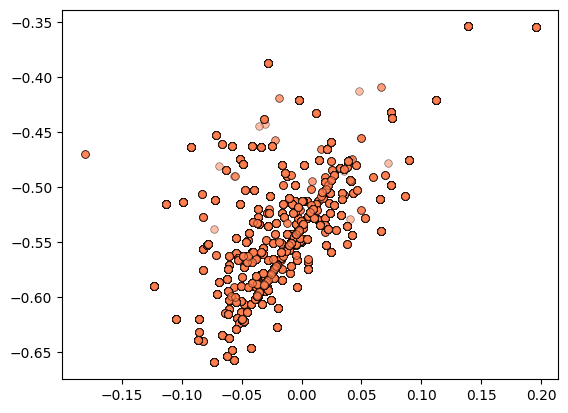

In [33]:
scatter(vae_x_chain[..., PROJ].view(-1, 2));

(-3.0, 3.0)

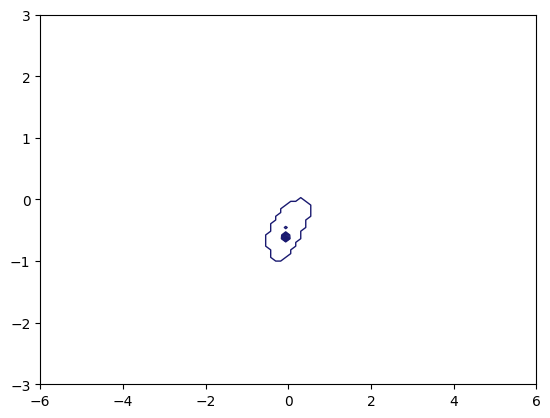

In [34]:
fig = plot_kde(vae_x_chain[..., PROJ], xlim, ylim)
ax = fig.get_axes()[0]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_aspect('equal')


(-3.0, 3.0)

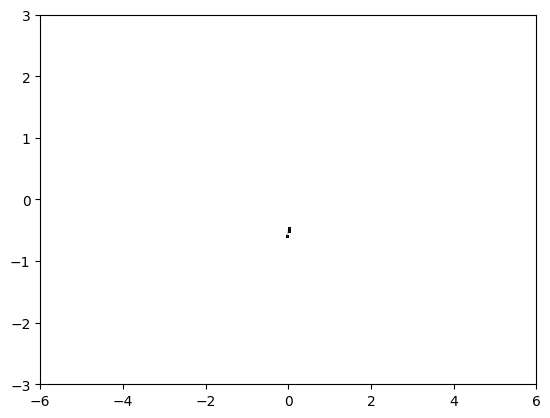

In [35]:
fig = plot_chain(vae_x_chain[:, 4, PROJ])
ax = fig.get_axes()[0]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_aspect('equal')


In [36]:
split_dim = max(AMB_DIM - HIDDEN_DIM, AMB_DIM // 2)
flows = [
    AffineCoupling(
        split_dim,
        DenseNN(
            split_dim,
            [HIDDEN_DIM],
            [AMB_DIM - split_dim, AMB_DIM - split_dim],
        ),
    )
    for _ in range(NUM_BLOCKS - 1)
]
split_dim = max(AMB_DIM - HIDDEN_DIM, AMB_DIM // 2)
flows.append(
    AffineCoupling(
        split_dim,
        DenseNN(
            split_dim,
            [HIDDEN_DIM],
            [AMB_DIM - split_dim, AMB_DIM - split_dim],
        ),
    )
)

rnvp = RNVP(flows=flows, dim=AMB_DIM)
rnvp_ml = FlowML(rnvp)
optimizer = torch.optim.Adam(rnvp_ml.parameters(), lr=3e-4)
trainer = Trainer(rnvp_ml, optimizer, train_dataloader, val_dataloader)

In [37]:
trainer.train(25)

2023-05-30 11:11:16,152 [INFO    ] 4%|4         | 1/25 [00:01<00:39,  1.63s/it]
2023-05-30 11:11:17,095 [INFO    ] Loss: 167.6068878173828
2023-05-30 11:11:19,421 [INFO    ] 12%|#2        | 3/25 [00:04<00:36,  1.64s/it]
2023-05-30 11:11:19,751 [INFO    ] Loss: 167.14134216308594
2023-05-30 11:11:21,115 [INFO    ] 16%|#6        | 4/25 [00:06<00:34,  1.66s/it]
2023-05-30 11:11:22,335 [INFO    ] Loss: 155.79095458984375
2023-05-30 11:11:24,087 [INFO    ] 24%|##4       | 6/25 [00:09<00:29,  1.56s/it]
2023-05-30 11:11:24,659 [INFO    ] Loss: 176.8344268798828
2023-05-30 11:11:25,491 [INFO    ] 28%|##8       | 7/25 [00:10<00:27,  1.51s/it]
2023-05-30 11:11:26,885 [INFO    ] Loss: 164.36895751953125
2023-05-30 11:11:28,562 [INFO    ] 36%|###6      | 9/25 [00:14<00:24,  1.54s/it]
2023-05-30 11:11:29,573 [INFO    ] Loss: 157.09237670898438
2023-05-30 11:11:32,373 [INFO    ] 44%|####4     | 11/25 [00:17<00:24,  1.74s/it]
2023-05-30 11:11:32,749 [INFO    ] Loss: 162.82293701171875
2023-05-30 11:1

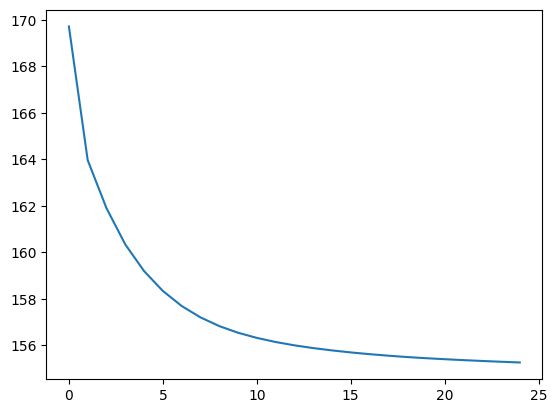

In [38]:
plt.plot(trainer.training_stats['epoch_loss'])

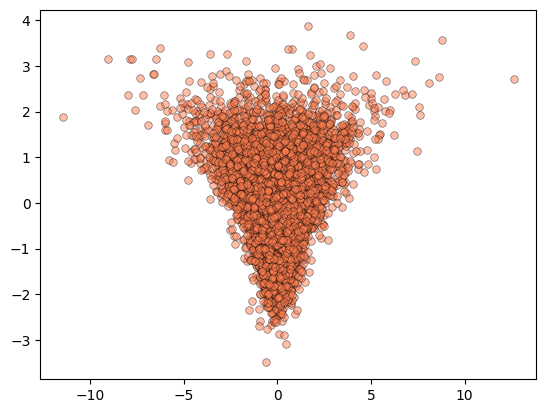

In [39]:
rnvp_sample = rnvp.sample((10000,)).detach().cpu()

scatter(rnvp_sample[:, PROJ]);

(-3.0, 3.0)

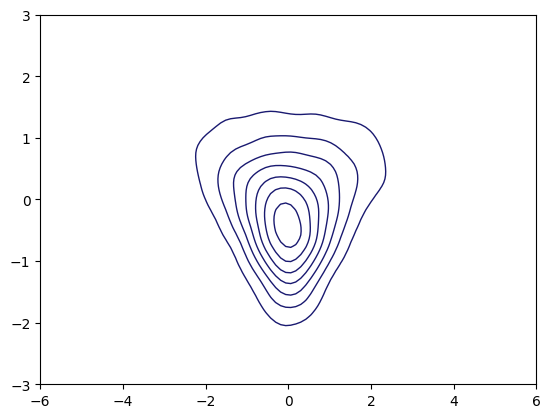

In [40]:
sample = rnvp.sample((20000,)).detach().cpu()
fig = plot_kde(sample[..., PROJ], xlim, ylim)
ax = fig.get_axes()[0]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_aspect('equal')


In [41]:
proposal = rnvp
isir_kernel = ISIRKernel(target, proposal=proposal, n_particles=25)

In [42]:
z_start = rnvp.sample((100,))
rnvp_x_chain = isir_kernel.run(z_start, 500, 500)

In [43]:
# x_start = flow.inverse(z_start)[0].detach().cpu()
# x_chain = flow.inverse(chain)[0].detach().cpu()
x_start = z_start.detach().cpu()
rnvp_x_chain = rnvp_x_chain.detach().cpu()

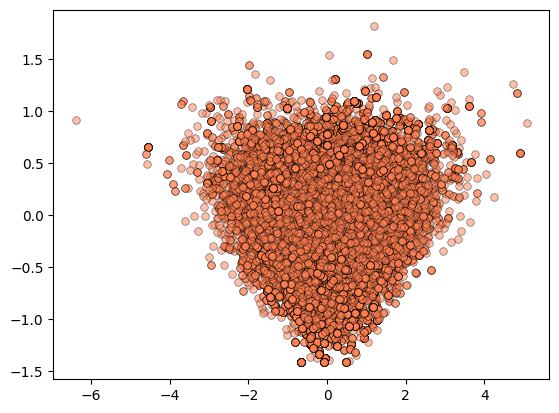

In [44]:
scatter(rnvp_x_chain[..., PROJ].view(-1, 2));


(-3.0, 3.0)

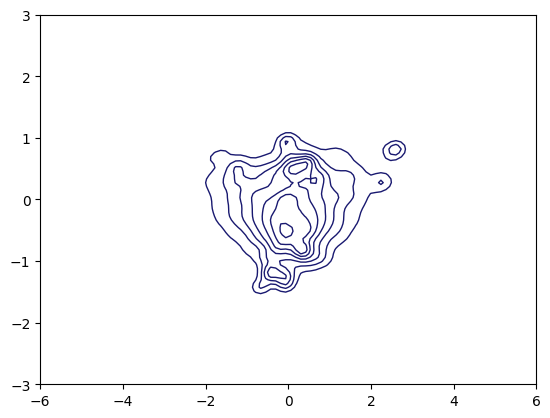

In [45]:
fig = plot_kde(rnvp_x_chain[..., PROJ], xlim, ylim)
ax = fig.get_axes()[0]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_aspect('equal')


(-3.0, 3.0)

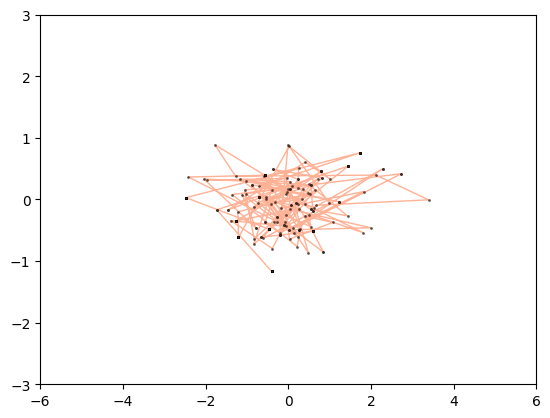

In [46]:
fig = plot_chain(rnvp_x_chain[:, 0, PROJ])
ax = fig.get_axes()[0]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_aspect('equal')


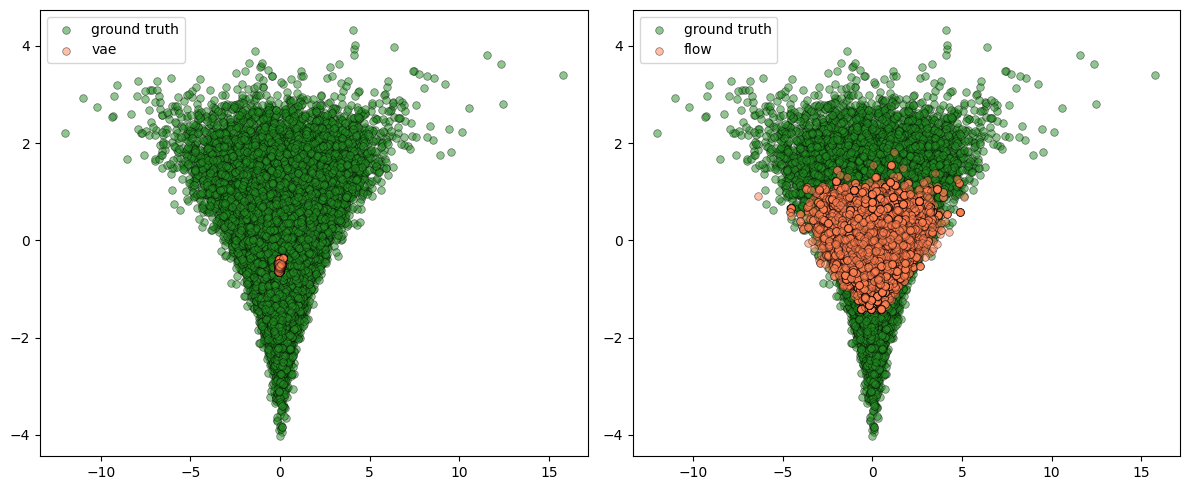

In [47]:

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

scatter(true_sample[..., PROJ], c='forestgreen', ax=axs[0], label='ground truth')
scatter(vae_x_chain[..., PROJ].view(-1, 2), ax=axs[0], label='vae')

scatter(true_sample[..., PROJ], c='forestgreen', ax=axs[1], label='ground truth')
scatter(rnvp_x_chain[..., PROJ].view(-1, 2), ax=axs[1], label='rnvp')

fig.tight_layout()
for ax in axs:
    ax.legend()
plt.savefig('../figs/vae_rnvp_funnel.png')